### Keras based LSTM model for sentiment detection

This LSTM model can be used for sentiment detection and has the following features which can be utlized by built in methods:

1) It can be scaled to any dataset where text and sentiment labels are  stored in columns of a Pandas dataframe.

2) Use optional pre-trained Word2Vec or GloVe based word embeddings for weights in an embedding layer.

3) The code plots the training and validation set accuracy and errors to see how the model is performing. 

4) Has methods to save and load the model for use in other applications.

In [1]:
import pandas as pd
import numpy as np
from kerasSentModel import kerasSentiment

pd.options.mode.chained_assignment = None



Using TensorFlow backend.


#### Import the dataset into a dataframe

In [2]:
data_df = pd.read_csv( "labelledTrainData.tsv", header=0, 
 delimiter="\t", quoting=3 )

##### Let us look at the data


In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
id           25000 non-null object
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(2)
memory usage: 586.0+ KB


In [4]:
data_df.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


#### Extract sentiment count. We see that we have a balanced data set 

In [5]:
data_df.sentiment.value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

#### We shall select a subset of data for training and holdout the rest for test

In [6]:
train_pct = 0.8
train_samples = np.int(train_pct * data_df.shape[0])
train_df = data_df.iloc[0:train_samples,:]


In [7]:
#replace empty cells with Nan
train_df.review.replace('', np.nan, inplace=True)
#drop null rows
train_df.dropna(inplace=True)

In [8]:
#Instantiate model
kerasModel = kerasSentiment()

##### Cleanup review column to remove HTML markup and non text characters

In [9]:
train_df['review'] = train_df.review.apply(lambda x : kerasModel.cleanup_review(x))

In [10]:
#assign train dataframe and define which columns have the data
kerasModel.text_df = train_df
kerasModel.text_colname = "review"
kerasModel.num_classes = 2
kerasModel.sentiment_colname = "sentiment"

#### The encodeTrainText method does a couple of things:
1) It encodes text with integer values

2) Pads reviews make sure they are all of same length

3) Returns binarized values of labels for training

In [11]:
#Get padded docs
padded_docs, labels= kerasModel.encodeTrainText()

Encoding and padding text..

Max sentence length in doc:2487

Encoding text..

Padding text..



#### Optionally use GloVe or Word2Vec embeddings 

We could optionally provide a pickle file containing a dict with the word as keys and embeddings as a value
The getPreTrainedEmbedding method then returns an embedding matrix based on words contained in the review corpus


In [12]:
#Use pre-Trained glove model
#kerasModel.glove_path = "glove6b_100d_Dict.pickle"
#embedding_matrix = kerasModel.getPretrainedEmbedding(embed_type="glove")

#### Create the model

We could optionally provide the embedding matrix created above as pre-trained weights for the embedding layer

In [13]:
#Create the model
#kerasModel.createModel(embedding_matrix=embedding_matrix,useTrainedEmbedding=True)
kerasModel.createModel()

Creating Keras model..

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2487, 100)         6781400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 6,811,651
Trainable params: 6,811,651
Non-trainable params: 0
_________________________________________________________________
None


#### Define model hyper parameters

In [16]:
#Model hyperparameters
kerasModel.lstm_units = 10
kerasModel.early_stop_epochs = 5
kerasModel.epochs = 5
kerasModel.batch_size = 128
kerasModel.verbose = True



#### Train the model using K-Fold cross validation

Training model using K-Fold cross val..

Train on 12800 samples, validate on 3200 samples
Epoch 1/5
12800/12800 [==============================] - 1157s 90ms/step - loss: 0.6934 - acc: 0.5003 - val_loss: 0.6931 - val_acc: 0.5041
Epoch 2/5
12800/12800 [==============================] - 1293s 101ms/step - loss: 0.6932 - acc: 0.5077 - val_loss: 0.6941 - val_acc: 0.5041
Epoch 3/5
12800/12800 [==============================] - 1296s 101ms/step - loss: 0.6934 - acc: 0.4950 - val_loss: 0.6932 - val_acc: 0.4959
Epoch 4/5
12800/12800 [==============================] - 1333s 104ms/step - loss: 0.6933 - acc: 0.5014 - val_loss: 0.6931 - val_acc: 0.5041
Epoch 5/5
12800/12800 [==============================] - 1448s 113ms/step - loss: 0.6933 - acc: 0.4964 - val_loss: 0.6933 - val_acc: 0.4959


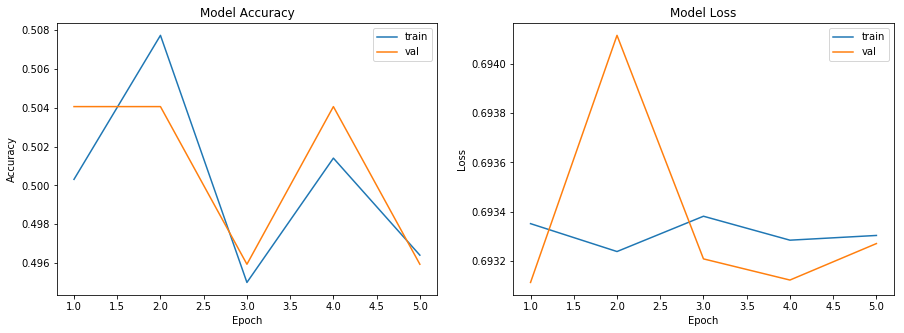

4000/4000 [==============================] - 85s 21ms/step

acc: 50.12%

Train on 12800 samples, validate on 3200 samples
Epoch 1/5
  640/12800 [>.............................] - ETA: 26:42 - loss: 0.6939 - acc: 0.4766

In [ ]:
#Train the model
kerasModel.trainModelKfold(padded_docs,labels)


In [ ]:
#Save model 
kerasModel.saveModel('kerasModelLSTM')